In [1]:
from utils import *
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [2]:
cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [3]:
# box = sys.argv[1]
box = 'Box_n50_0_1400'
# box = 'Box0_1400'
# a_RUN = float(sys.argv[2])
a_RUN = 0.787402

# box = 'Box0_1400'

h = cosmo_params[box]['H0']/100

Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f) #Pkz is a dictonary of functions
Pk_f.close()

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

#deal with floating point errors
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))

In [4]:
def log_prior(param_values):
    #uniform prior
    for param in param_values:
        if(param< 0 or param>15):
            return -np.inf
    return 0

def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(log_prior(param_values) == -np.inf):
        return -np.inf
    
    params = dict(zip(param_names, param_values))
    tinker_fs = {}
    
    for a in N_data:
        tinker_eval = [tinker(a, M_c,**params,)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = {}
    for a in N_data:
#         if(a_to_z[a] >=2):
# #             print(1)
#             continue
        model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
            for edge_pair in NvMs[a]['edge_pairs']
        ])
    
    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)

def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)



In [5]:
print(cosmo_params[box])

{'As': 2.10100315, 'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, 'sigma': 0.81001457}


In [6]:
tot_sampler = None
param_names = [ 'd0', 'd1',
               'e0', 'e1',
               'f0', 'f1',
               'g0','g1']
ndim = len(param_names)

with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
    tot_sampler = pickle.load(f)
samples = tot_sampler.chain[:, 9000:, :].reshape((-1, ndim))
final_param_vals = np.percentile(samples,  50,axis=0)
params_final_tot = dict(zip(param_names, final_param_vals))
print(params_final_tot)

{'d0': 1.4495498364480985, 'd1': -1.815572661250965, 'e0': 0.9916492675649499, 'e1': 3.966070319207637, 'f0': 1.4404376457417187, 'f1': 1.071171435177291, 'g0': 0.799237386037459, 'g1': 0.606875394804077}


In [11]:
samplers = {}
final_params= {}
param_names = [ 'd',
               'e',
               'f',
               'g',]

ndim = len(param_names)
a_data = []
p_data = dict(zip(param_names, [[] for _ in range(ndim)]))
for key in a_to_z:
    if(key == 0.25 or key==0.620002):
        continue
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_individ_MCMC_sampler.pkl"%(box,key), "rb") as f:
        samplers[key] = pickle.load(f)
    samples = samplers[key].chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    final_params[key] = dict(zip(param_names, final_param_vals))
    a_data += [key]
    for p in final_params[key]:
        p_data[p]+= [final_params[key][p]]
    

In [12]:
def p_get(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

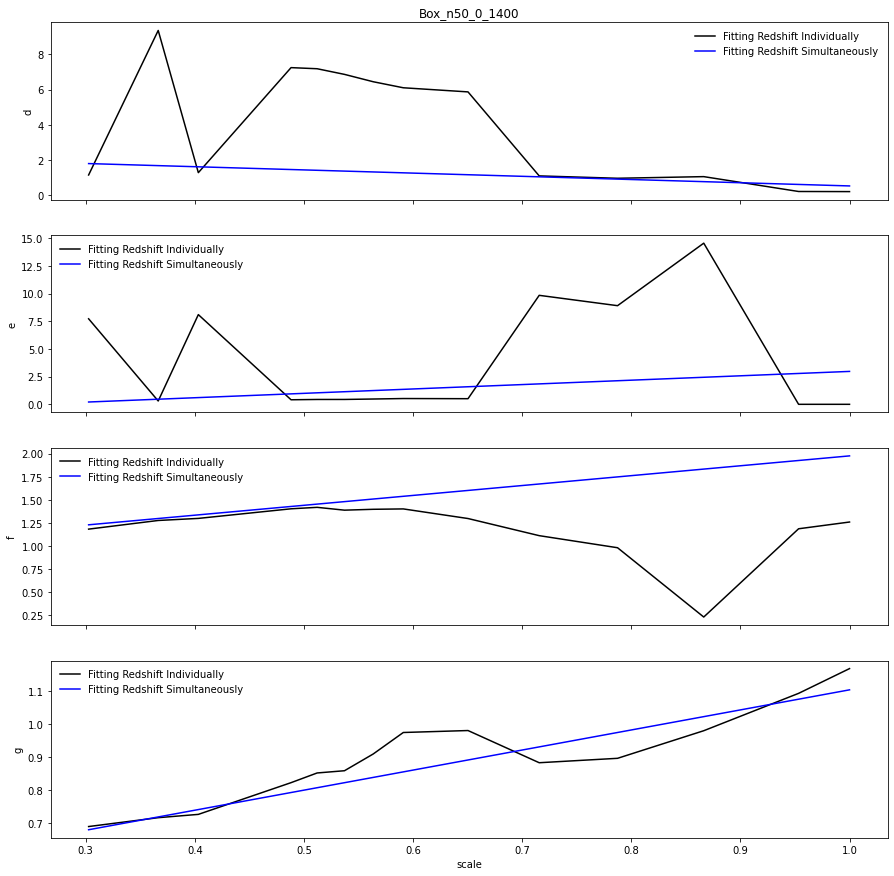

In [13]:
fig, axs = plt.subplots(nrows=ndim, figsize=(15,15), sharex=True)
for (i, param) in enumerate(p_data):
    axs[i].plot(a_data, p_data[param],color='Black',label='Fitting Redshift Individually')
    axs[i].plot(a_data, [p_get(a_cur, 
                               params_final_tot['%s0'%param], 
                               params_final_tot['%s1'%param]) for a_cur in a_data],
               color='Blue', label='Fitting Redshift Simultaneously'
               )
    axs[i].legend(frameon=False)
    axs[i].set_ylabel(param)
axs[0].set_title(box)
axs[-1].set_xlabel('scale')
plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_individ_vs_total.pdf'%(box), bbox_inches='tight')
